# Business Problem





In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
shots_df = pd.read_csv('shots_2022.csv')
buffalo_df = pd.read_csv('BUF.csv')
buffalo_player_stats = pd.read_csv('buf_player_stats.csv')
boston_player_stats = pd.read_csv('BOS.csv')
boston_df = pd.read_csv('BOS_team_stats.csv')

# Data Clean Up

I only want to focus on the most current season, the 2022 season.  Usually the more data the better, however we do not want to include players that are not on either team anymore. 

In [3]:
buffalo_2022 = buffalo_df[buffalo_df['season'] == 2022]

In [4]:
boston_df['gameId'] = boston_df['gameId'].astype(str)
boston_2022 = boston_df[boston_df['gameId'].str[:4] == '2022']

Both boston and buffalo have their own dfs that focus on the current (2022) season

In [5]:
combined_2022_df = pd.concat([boston_2022, buffalo_2022])

In [6]:
combined_2022_df.isna().sum().sum()

340

After removing the season column (we know its all 2022) there is no more missing values

In [7]:
combined_2022_df.isna().sum().sum()

340

In [8]:
combined_2022_df.drop("season", axis=1, inplace=True)

In [9]:
combined_2022_df.isna().sum().sum()

0

Now that the seasons column has been removed (we know its all the 2022 season now) there are no missing values.

# EDA

I want to compare Buffalo's total "goalsFor" and the total  "goalsAgainst" to that of Bostons.

In [10]:
situation_all_df = combined_2022_df[combined_2022_df['situation'] == 'all']
team_goals = situation_all_df.groupby('team').sum()[['goalsFor', 'goalsAgainst']]
print(team_goals)

      goalsFor  goalsAgainst
team                        
BOS      254.0         147.0
BUF      247.0         247.0


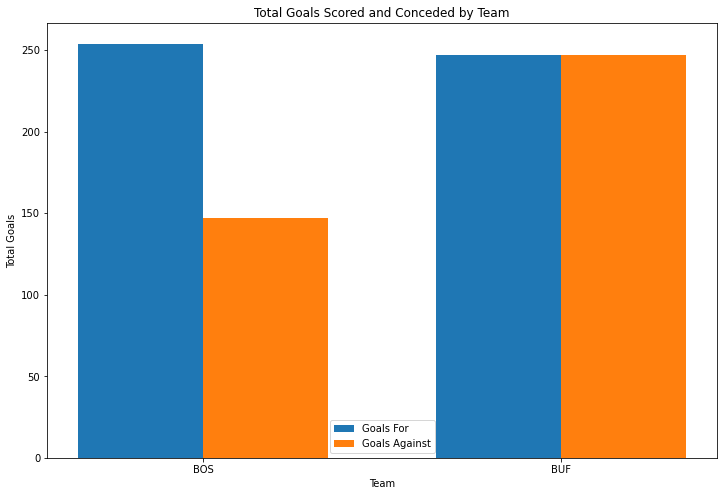

In [11]:
# Group the resulting DataFrame by the 'team' column, and sum the 'goalsFor' and 'goalsAgainst' columns within each group
team_goals = situation_all_df.groupby('team').sum()[['goalsFor', 'goalsAgainst']]

# Get the list of team names and the number of teams
team_names = list(team_goals.index)
num_teams = len(team_names)

# Create a numpy array for the goalsFor and goalsAgainst data
goals_for_data = np.array(team_goals['goalsFor'])
goals_against_data = np.array(team_goals['goalsAgainst'])

# Define the width of the bars
bar_width = 0.35

# Create a numpy array for the x-axis positions of the bars
x_positions = np.arange(num_teams)

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Create the bars for goalsFor and goalsAgainst for each team
ax.bar(x_positions - bar_width/2, goals_for_data, bar_width, label='Goals For')
ax.bar(x_positions + bar_width/2, goals_against_data, bar_width, label='Goals Against')

# Set the title and axis labels for the chart
plt.title('Total Goals Scored and Conceded by Team')
plt.xlabel('Team')
plt.ylabel('Total Goals')

# Set the tick labels for the x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(team_names)

# Add a legend for the bars
ax.legend()

# Show the chart
plt.show()

Looking at this, we can see that Boston (a serious Stanley Cup contender) scores about 100 more goals than they let in.  Buffalo on the other hand is dead even, 247 "goalsFor", and 247 "goalsAgainst". Also, Buffalo has a total "goalsFor" that is very similar to Boston's. This tells me that Buffalo has an offense that is on par with one of the best teams in the league, but their defense is far behind.

Now we will try to explain why Boston's defense is letting in so few goals compared to Buffalo.

# Defense Analysis

I want to compare the defense for different situations for both teams to focus in on why why Boston allows so many fewer goals

Situation percentages for each team:
situation  4on5  5on4  5on5    all  other
team                                     
BOS        21.1   3.4  64.6  100.0   10.9
BUF        19.0   2.0  66.8  100.0   12.1


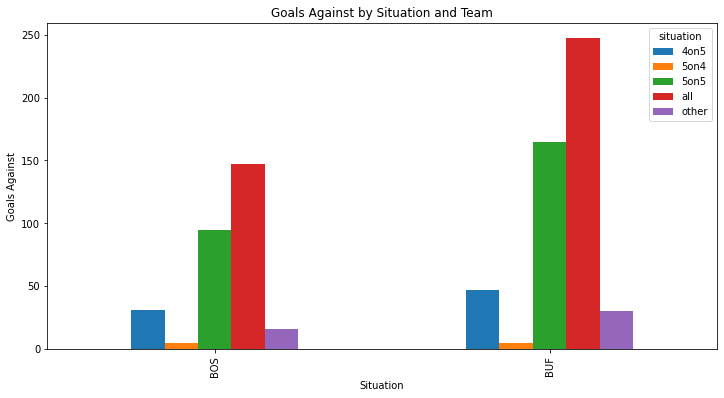

In [12]:
# Group the data by team and situation and get the sum of goalsAgainst
team_situation_goals = combined_2022_df.groupby(['team', 'situation']).sum()['goalsAgainst']

# Reshape the data to a wide format
team_situation_goals = team_situation_goals.unstack()

# Calculate the total goalsAgainst for each team
total_goals = team_situation_goals.sum(axis=1)

# Calculate the percentage of each situation's goalsAgainst out of the team's total goalsAgainst
situation_percentages = (team_situation_goals.div(total_goals, axis=0) * 100 * 2).round(1)

# Print the list of percentages for each situation
print("Situation percentages for each team:")
print(situation_percentages)

# Plot the data
team_situation_goals.plot(kind='bar', figsize=(12, 6))

# Set the plot title and labels
plt.title('Goals Against by Situation and Team')
plt.xlabel('Situation')
plt.ylabel('Goals Against')

# Show the plot
plt.show()

Percentages for both teams are close to each other for percentages of goals against in each situation. This indicates that buffalo allows too many goals all together, rather than just being particularly bad in one situation.  Next we can look into what features correlate to allowing a goal for buffalo's complete goalsAgainst total.

# Buffalo's goalsAgainst most relevant features

In [13]:
# Drop columns that contain 'flurry' or 'Flurry' in their names
buffalo_2022_filtered = buffalo_2022.drop(columns=[col for col in buffalo_2022.columns if 'flurry' in col.lower()])

# Filter the dataframe to only include rows where situation is "all"
buffalo_2022_filtered = buffalo_2022_filtered[buffalo_2022_filtered['situation'] == 'all']

# Calculate the correlation between each column and goalsAgainst
correlations = buffalo_2022_filtered.corr()['goalsAgainst']

# Get the top 12 correlations (excluding the correlation with goalsAgainst itself)
top_correlations = correlations.nlargest(13)[1:]

# Print the top 12 correlations
print(top_correlations)

highDangerGoalsAgainst                 0.672946
mediumDangerGoalsAgainst               0.595512
scoreAdjustedTotalShotCreditAgainst    0.466992
scoreVenueAdjustedxGoalsAgainst        0.393520
totalShotCreditAgainst                 0.384837
highDangerxGoalsAgainst                0.354096
lowDangerGoalsAgainst                  0.345214
reboundGoalsAgainst                    0.320879
xGoalsAgainst                          0.315013
highDangerShotsAgainst                 0.258818
playStoppedAgainst                     0.187315
gameId                                 0.168217
Name: goalsAgainst, dtype: float64


We can see that highDangerGoalsAgainst and mediumDangerGoalsAgainst are the top two correlated features to goalsAgainst.  This indicates that Buffalo is allowing teams to get to these areas to easily.  Next let's compare this list of features to the features that are relevant to Boston (cup contender) being scored on.

# Boston's goalsAgainst most relevant features

In [14]:
# Drop columns that contain 'flurry' or 'Flurry' in their names
boston_2022_filtered = boston_2022.drop(columns=[col for col in buffalo_2022.columns if 'flurry' in col.lower()])

# Filter the dataframe to only include rows where situation is "all"
boston_2022_filtered = boston_2022_filtered[boston_2022_filtered['situation'] == 'all']

# Calculate the correlation between each column and goalsAgainst
correlations = boston_2022_filtered.corr()['goalsAgainst']

# Get the top 12 correlations (excluding the correlation with goalsAgainst itself)
top_correlations = correlations.nlargest(13)[1:]

# Print the top 12 correlations
print(top_correlations)

mediumDangerGoalsAgainst               0.623421
highDangerGoalsAgainst                 0.572474
scoreAdjustedTotalShotCreditAgainst    0.520825
totalShotCreditAgainst                 0.500354
scoreVenueAdjustedxGoalsAgainst        0.474769
xGoalsAgainst                          0.458834
mediumDangerShotsAgainst               0.452626
lowDangerGoalsAgainst                  0.436365
mediumDangerxGoalsAgainst              0.436138
reboundGoalsAgainst                    0.393949
highDangerShotsAgainst                 0.359798
playContinuedInZoneFor                 0.341447
Name: goalsAgainst, dtype: float64


We see a few similar features here.  However one thing we should note here is that highDangerGoalsAgainst for Boston is lower than for Buffalo.  To me this means that Boston is doing a better job of keeping shooters out of the high danger areas.  Boston's high danger goalsAgainst are .10 lower than Buffalo.

In [15]:
situation_all_df

,team,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,xGoalsPercentage,...,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
1,BOS,BOS,2022020005,BOS,WSH,AWAY,20221012,Team Level,all,0.5323,...,62.005,46.0,43.172,7.0,0.538,0.212,0.212,3.082,2.937,2.801
6,BOS,BOS,2022020027,BOS,ARI,HOME,20221015,Team Level,all,0.6985,...,44.967,33.0,32.216,3.0,0.381,0.225,0.225,2.545,2.545,2.530
11,BOS,BOS,2022020041,BOS,FLA,HOME,20221017,Team Level,all,0.5490,...,77.245,56.0,55.373,0.0,0.867,1.571,1.571,3.100,3.119,3.022
16,BOS,BOS,2022020049,BOS,OTT,AWAY,20221018,Team Level,all,0.4741,...,62.238,47.0,48.161,6.0,0.557,0.509,0.509,3.989,4.007,3.965
21,BOS,BOS,2022020059,BOS,ANA,HOME,20221020,Team Level,all,0.6459,...,49.917,39.0,39.564,3.0,0.377,0.010,0.010,1.910,1.962,1.925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,BUF,BUF,2022021025,BUF,DAL,HOME,20230309,Team Level,all,0.2916,...,75.615,58.0,65.151,1.0,0.710,0.036,0.036,4.969,5.506,5.404
5696,BUF,BUF,2022021040,BUF,NYR,HOME,20230311,Team Level,all,0.5431,...,53.127,38.0,38.666,3.0,0.513,0.201,0.201,2.519,2.580,2.378
5701,BUF,BUF,2022021061,BUF,TOR,AWAY,20230313,Team Level,all,0.6560,...,47.833,39.0,38.148,11.0,0.385,0.266,0.266,1.970,1.911,1.869
5706,BUF,BUF,2022021076,BUF,WSH,AWAY,20230315,Team Level,all,0.4239,...,64.443,50.0,46.268,11.0,0.619,0.968,0.968,3.194,2.987,2.931


We are now looking into what the difference in goals is for Boston and Buffalo when beiong scored on from a high danger areas.

In [16]:
# Filter the dataframe to only include high danger goals against
high_danger_df = situation_all_df[situation_all_df['situation'] == 'all'][['team', 'goalsAgainst', 'highDangerGoalsAgainst']]

# Group the dataframe by team and sum the high danger goals against
team_high_danger_df = high_danger_df.groupby('team').sum()

# Print the resulting dataframe
print(team_high_danger_df)

      goalsAgainst  highDangerGoalsAgainst
team                                      
BOS          147.0                    51.0
BUF          247.0                    81.0


Buffalo allows 30 more goals from high danger areas.  When games can be won by one or two goals this can be a serious problem.  Buffalo is one of the top scoring teams in the league but allows so many goals.

In [17]:
shots_df

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,...,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
0,0,43.0,47.0,47.0,8.0,8.0,0.000000,0,0,0,...,44,0.214393,0.026009,0.398742,0.300830,0.022987,0.037040,0.710473,8,8
1,1,51.0,45.0,45.0,26.0,26.0,0.000000,0,0,0,...,44,0.186673,0.007774,0.455486,0.294453,0.020666,0.034948,0.667152,27,27
2,2,59.0,-31.0,31.0,8.0,8.0,0.000000,0,0,0,...,33,0.256798,0.046070,0.358080,0.259696,0.027936,0.051420,0.644651,8,-8
3,3,14.0,-76.0,76.0,-4.0,4.0,0.000000,0,0,0,...,74,0.172590,0.296800,0.230564,0.183049,0.024885,0.092112,0.898032,-5,5
4,4,14.0,-82.0,82.0,12.0,12.0,0.000000,0,0,0,...,81,0.128260,0.057435,0.446106,0.286419,0.019556,0.062224,0.759405,15,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95093,352,40.0,-58.0,58.0,-26.0,26.0,5.833333,1,0,0,...,60,0.149341,0.061693,0.457400,0.265860,0.024608,0.041097,0.740899,-24,24
95094,353,46.0,55.0,55.0,31.0,31.0,0.000000,1,0,0,...,55,0.039771,0.341653,0.280115,0.295717,0.021925,0.020818,0.441629,31,31
95095,354,72.0,-20.0,20.0,-20.0,20.0,0.000000,1,0,0,...,19,0.013367,0.467303,0.192696,0.293724,0.021852,0.011058,0.472695,-20,20
95096,355,60.0,29.0,29.0,-3.0,3.0,0.833333,1,0,0,...,30,0.008746,0.847586,0.065123,0.064332,0.007230,0.006983,0.746178,-3,-3


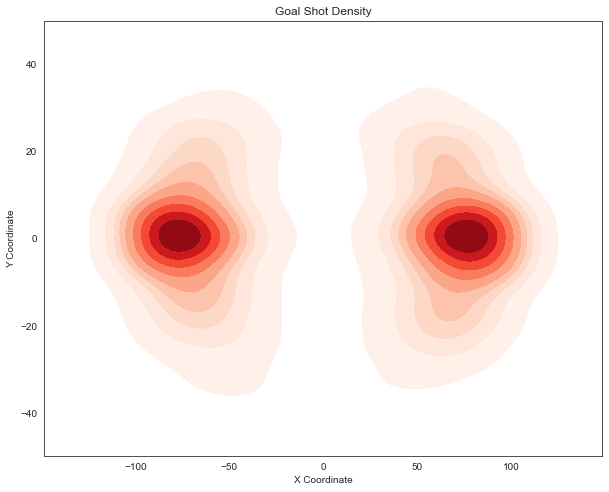

In [18]:
# Filter out the shots that didn't result in a goal
goal_shots = shots_df[shots_df["goal"] == 1]

# Set the style of the plot
sns.set_style("white")

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the goal shots density map
sns.kdeplot(x=goal_shots["xCord"], y=goal_shots["yCord"], shade=True, cmap="Reds", ax=ax)
ax.set_title("Goal Shot Density")

# Set the plot title and axis labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# Show the plot
plt.show()

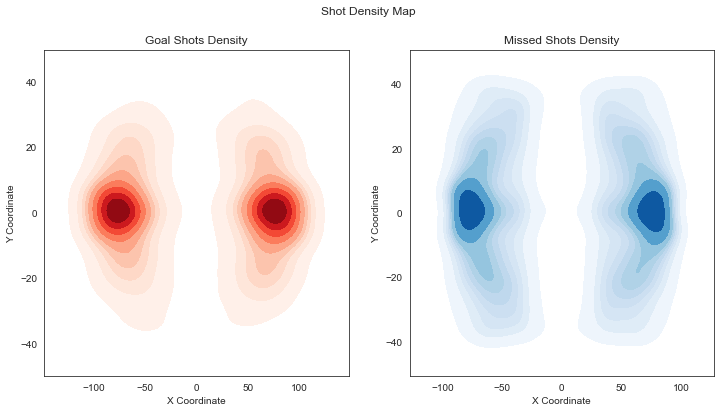

In [19]:
# Filter out the shots that didn't result in a goal
goal_shots = shots_df[shots_df["goal"] == 1]
missed_shots = shots_df[shots_df["goal"] == 0]

# Set the style of the plot
sns.set_style("white")

# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the goal shots density map in the first subplot
sns.kdeplot(x=goal_shots["xCord"], y=goal_shots["yCord"], shade=True, cmap="Reds", ax=axs[0])
axs[0].set_title("Goal Shots Density")

# Plot the missed shots density map in the second subplot
sns.kdeplot(x=missed_shots["xCord"], y=missed_shots["yCord"], shade=True, cmap="Blues", ax=axs[1])
axs[1].set_title("Missed Shots Density")

# Set the plot title and axis labels
fig.suptitle("Shot Density Map")
axs[0].set_xlabel("X Coordinate")
axs[0].set_ylabel("Y Coordinate")
axs[1].set_xlabel("X Coordinate")
axs[1].set_ylabel("Y Coordinate")

# Show the plot
plt.show()

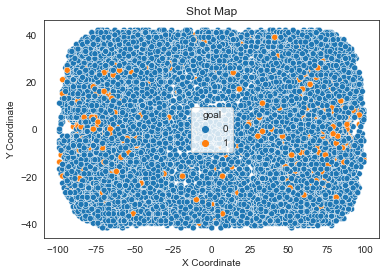

In [20]:
# Plot the shots with different hues based on whether they resulted in a goal or not
sns.scatterplot(data=shots_df, x="xCord", y="yCord", hue="goal")

# Set the plot title and axis labels
plt.title("Shot Map")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Show the plot
plt.show()

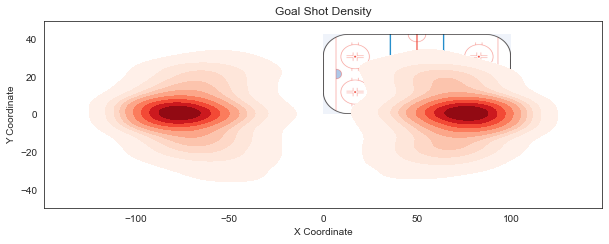

In [21]:
# Load the hockey rink image
rink_img = mpimg.imread("hockeyRink.png")

# Filter out the shots that didn't result in a goal
goal_shots = shots_df[shots_df["goal"] == 1]

# Set the style of the plot
sns.set_style("white")

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the hockey rink image
ax.imshow(rink_img, extent=[0, 100, 0, 42.5])

# Plot the goal shots density map on top of the rink image
sns.kdeplot(x=goal_shots["xCord"], y=goal_shots["yCord"], shade=True, cmap="Reds", ax=ax)

# Set the plot title and axis labels
ax.set_title("Goal Shot Density")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# Show the plot
plt.show()

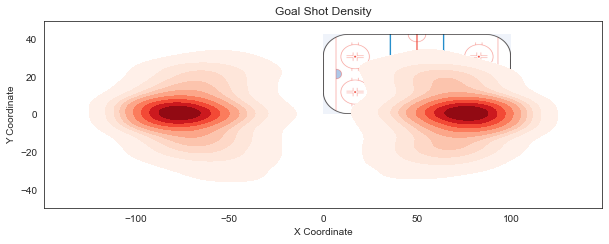

In [22]:
# Load the hockey rink image
rink_img = mpimg.imread("hockeyRink.png")

# Filter out the shots that didn't result in a goal
goal_shots = shots_df[shots_df["goal"] == 1]

# Set the style of the plot
sns.set_style("white")

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Set the x and y ranges of the plot
x_range = [0, 100]
y_range = [0, 42.5]

# Plot the hockey rink image, fitted to the x and y ranges of the goal shots
ax.imshow(rink_img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])

# Plot the goal shots density map on top of the rink image
sns.kdeplot(x=goal_shots["xCord"], y=goal_shots["yCord"], shade=True, cmap="Reds", ax=ax)

# Set the plot title and axis labels
ax.set_title("Goal Shot Density")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# Show the plot
plt.show()